[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Example 5.14, and Figures 5.12 and 5.13

Analysis of hourly temperature data from 2015 in Corvallis (Oregon), Manhattan (Kansas) and Versailles (Kentucky)\
Topics: Joint probability density function, marginal distribution, conditional distribution, conditional independence

Author: Carlos Fernandez-Granda
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

font_size = 12
font_size_ticks = 12

np.set_printoptions(precision=3)

file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"

data_matrix = np.load(file_name_temperature_2015)

file_name_list = np.load('../data/weather/weather_station_names.npy')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [27]:
stations = [52,55,100] 
station_names = []
for station in stations:
    name = process_name(file_name_list[station])
    station_names.append(name)
    print(name) 

Manhattan, KS
Versailles, KY
Corvallis, OR


In [28]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

station_1 = process_name(file_name_list[stations[0]+1])
station_2 = process_name(file_name_list[stations[1]+1])

verbose = False
temperature_1 = remove_faulty_measurements(data_matrix[:,stations[0]],verbose)
temperature_2 = remove_faulty_measurements(data_matrix[:,stations[1]],verbose)
temperature_3 = remove_faulty_measurements(data_matrix[:,stations[2]],verbose)

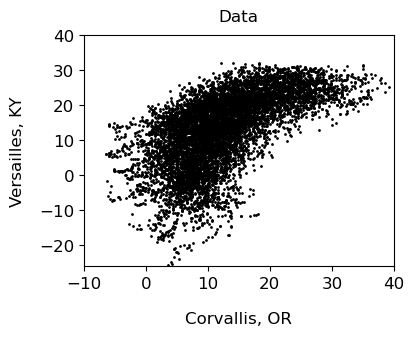

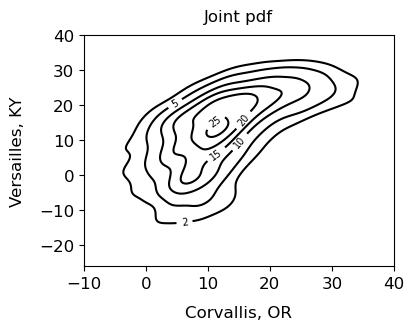

In [29]:
def KDE_2D(data_1,data_2,t_1,t_2,bw=None):
    x,y = np.meshgrid(t_1,t_2)
    grid = np.vstack([x.ravel(), y.ravel()])
    values = np.vstack([data_1, data_2])
    kernel = stats.gaussian_kde(values,bw_method=bw)
    kde = np.reshape(kernel(grid).T, x.shape)
    return kde

def fmt(x):
    s = f"{x:.4f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

xmin = -10
xmax = 40
ymin = -26
ymax = 40

t_2 = np.linspace(ymin,ymax,500)
t_3 = np.linspace(xmin,xmax,500)

markersize =1 
plt.figure(figsize=(4,3))
plt.scatter(temperature_3,temperature_2,s=markersize,color="black",rasterized=True)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([ymin,ymax])
plt.xlim([xmin,xmax])
plt.ylabel(station_names[1],fontsize=font_size,labelpad = 10)
plt.xlabel(station_names[2],fontsize=font_size,labelpad = 15)
plt.title("Data",fontsize=font_size,pad = 10);

# Bandwidth parameter for kernel density estimation
bw_vals = [0.25]# [0.1,0.25,0.5]

levels = [2,5,10,15,20,25,30]

for ind,bw in enumerate(bw_vals):
    kde = KDE_2D(temperature_3,temperature_2,t_3,t_2,bw=bw)
    plt.figure(figsize=(4,3))
    CS = plt.contour(t_3, t_2, 1e4*kde, levels=levels,colors='black')
    plt.clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=font_size_ticks-5)
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    plt.ylabel(station_names[1],fontsize=font_size,labelpad = 10)
    plt.xlabel(station_names[2],fontsize=font_size,labelpad = 10)
    plt.title("Joint pdf",fontsize=font_size,pad = 10);

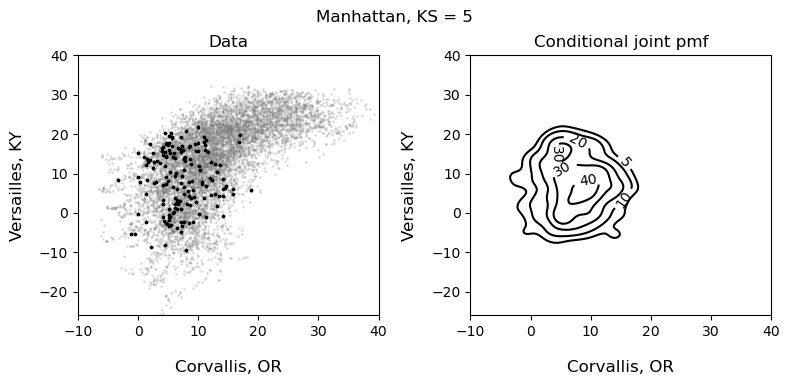

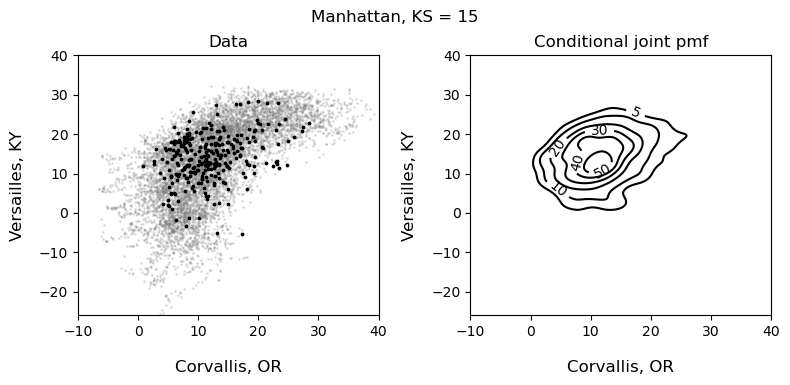

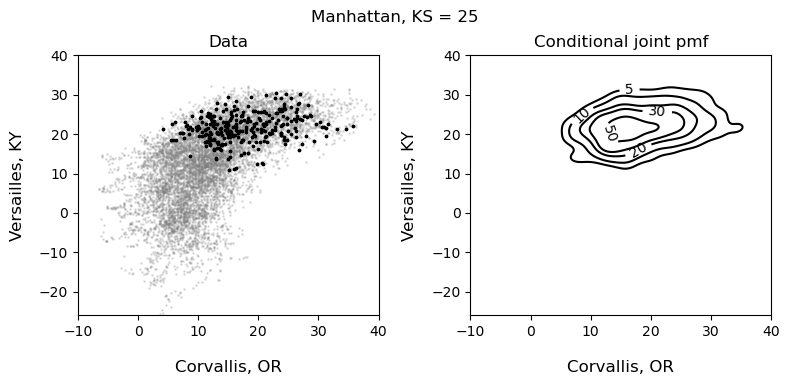

In [30]:
# 2D conditional distributions

def KDE_2D_cond(data_1,data_2,data_cond,val_cond,t1,t2,bw_1D=None,bw_3D=None,verbose=False):
    x,y,z = np.meshgrid(t1,t2,val_cond)
    grid = np.vstack([x.ravel(), y.ravel(),z.ravel()])
    if verbose:
        print("Grid:")
        print(grid)
    values = np.vstack([data_1,data_2,data_cond])
    kernel_3D = stats.gaussian_kde(values,bw_method=bw_3D)
    kde_3D = np.reshape(kernel_3D(grid).T, x.shape)
    if verbose:
        print("kde_3D: ")
        print(kde_3D)
        print("dimensions: ")
        print(kde_3D.shape)
    kernel_1D = stats.gaussian_kde(data_cond,bw_method=bw_1D)
    kde_1D = kernel_1D(val_cond)
    if verbose:
        print("kde_1D: ")
        print(kde_1D)
    kde_cond = kde_3D / kde_1D
    return kde_cond[:,:,0]

bw_1D = 0.25
bw_3D = 0.25
epsilon = 0.5 # We consider temperatures within 1 degree
verbose = False
t_cond = [5,15,25]
levels = [5,10,20,30,40,50]#,50,60,70,80]
levels_aux = [5,10,20,30,50]

for ind,t_val in enumerate(t_cond):
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4),width_ratios=[1,1])
    fig.suptitle(station_names[0] + " = " + str(t_val),fontsize=font_size,y = 0.95)
    
    indices = np.where(np.logical_and(temperature_1 >= t_val - epsilon, temperature_1 <= t_val + epsilon))
    temperature_cond_2 = temperature_2[indices]
    temperature_cond_3 = temperature_3[indices]
    
    markersize =1 
    axes[0].scatter(temperature_3,temperature_2,s=markersize,color="gray",alpha=0.2,rasterized=True)
    axes[0].scatter(temperature_cond_3,temperature_cond_2,s=markersize+2,color="black",rasterized=True) 
    axes[0].set_ylim([ymin,ymax])
    axes[0].set_xlim([xmin,xmax])
    axes[0].set_ylabel(station_names[1],fontsize=font_size,labelpad=10)
    axes[0].set_xlabel(station_names[2],fontsize=font_size,labelpad = 15)
    axes[0].set_title("Data",fontsize=font_size)

    kde = KDE_2D_cond(temperature_3,temperature_2,temperature_1,t_val,t_3,t_2,bw_1D=bw_1D,bw_3D=bw_3D,verbose=verbose)
    if ind == 2:
        CS = axes[1].contour(t_3,t_2, 1e4*kde, levels=levels_aux,colors='black')
    else:
        CS = axes[1].contour(t_3,t_2, 1e4*kde, levels=levels,colors='black')
    axes[1].clabel(CS, CS.levels, inline=True, fmt=fmt)
    axes[1].set_ylim([ymin,ymax])
    axes[1].set_xlim([xmin,xmax])
    axes[1].set_ylabel(station_names[1],fontsize=font_size,labelpad = 10)
    axes[1].set_xlabel(station_names[2],fontsize=font_size,labelpad = 15)
    axes[1].set_title("Conditional joint pmf",fontsize=font_size)
    plt.tight_layout();

In [31]:
# Estimation of 1D conditional pdfs via kernel density estimation 

def KDE_1D(data,x,bw=None):
    kernel = stats.gaussian_kde(data,bw_method=bw)
    kde = kernel(x)
    return kde

def KDE_cond(data,data_cond,val_cond,t,bw_1D=None,bw_2D=None,verbose=False):
    xmin = data.min()
    xmax = data.max()
    x,y = np.meshgrid(t,val_cond)
    grid = np.vstack([x.ravel(), y.ravel()])
    if verbose:
        print("Grid:")
        print(grid)
    values = np.vstack([data, data_cond])
    kernel_2D = stats.gaussian_kde(values,bw_method=bw_2D)
    kde_2D = np.reshape(kernel_2D(grid).T, x.shape)
    if verbose:
        print("kde_2D: ")
        print(kde_2D)
    kernel_1D = stats.gaussian_kde(data_cond,bw_method=bw)
    kde_1D = kernel_1D(val_cond)
    if verbose:
        print("kde_1D: ")
        print(kde_1D)
    kde_cond = kde_2D / kde_1D
    return kde_cond[0]

def KDE_cond_2(data,data_cond_1,data_cond_2,val_cond_1,val_cond_2,t,bw_2D=None,bw_3D=None,verbose=False):
    x,y,z = np.meshgrid(t,val_cond_1,val_cond_2)
    grid = np.vstack([x.ravel(), y.ravel(),z.ravel()])
    if verbose:
        print("Grid:")
        print(grid)
    values = np.vstack([data,data_cond_1,data_cond_2])
    kernel_3D = stats.gaussian_kde(values,bw_method=bw_3D)
    kde_3D = np.reshape(kernel_3D(grid).T, x.shape)
    if verbose:
        print("kde_3D: ")
        print(kde_3D)
        print("dimensions: ")
        print(kde_3D.shape)
    values_2D = np.vstack([data_cond_1,data_cond_2])
    kernel_2D = stats.gaussian_kde(values_2D,bw_method=bw_1D)
    kde_2D = kernel_2D(np.vstack([val_cond_1,val_cond_2]))
    if verbose:
        print("kde_2D: ")
        print(kde_2D)
    kde_cond = kde_3D / kde_2D
    return kde_cond[0]

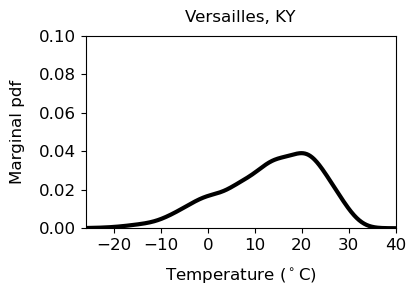

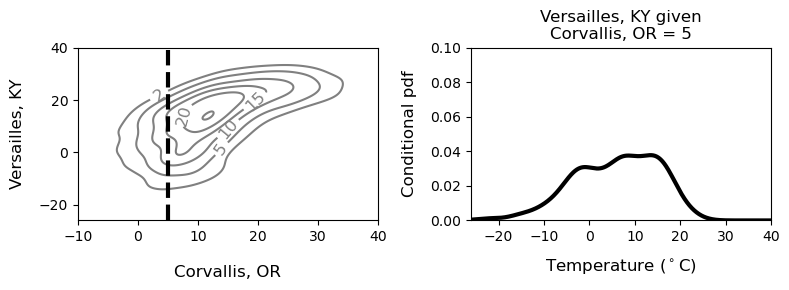

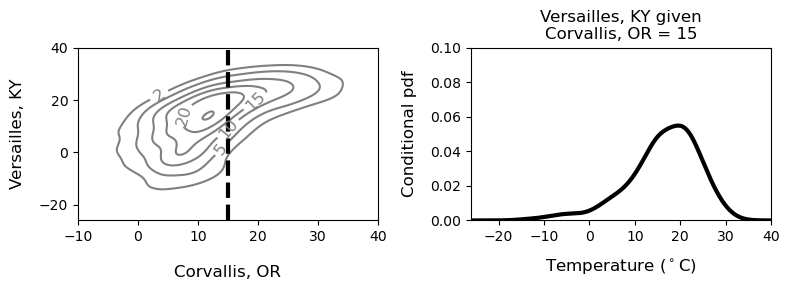

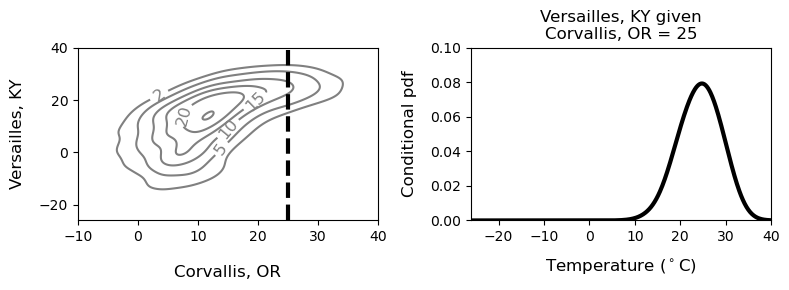

In [32]:
# The temperatures in Versailles and Corvallis are very dependent
verbose = False
t_cond = [5,15,25]
y_max = 0.1

ymin = -26
ymax = 40
    
bw = 0.25
kde = KDE_1D(temperature_2,t_2,bw=bw)
plt.figure(figsize=(4,2.5))
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(t_2,kde,color="black",lw=3)
plt.xlim([ymin,ymax])
plt.ylim([0,y_max])
plt.ylabel(r"Marginal pdf",fontsize=font_size,labelpad=10)
plt.title(station_names[1],fontsize=font_size,pad=10)
plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=10)

for ind,t_val in enumerate(t_cond):
    
    bw_1D = 0.3
    bw_2D = 0.3
    bw_3D = 0.3

    fig, axes = plt.subplots(1, 2, figsize=(8,3),width_ratios=[1,1])
    
    ymin = -26
    ymax = 40
    
    kde = KDE_2D(temperature_3,temperature_2,t_3,t_2,bw=bw_1D)
    levels = [2,5,10,15,20,25,30]
    CS = axes[0].contour(t_3,t_2, 1e4*kde, levels=levels,colors='gray')
    axes[0].clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=font_size_ticks)
    axes[0].vlines(t_val,ymin,ymax,lw=3,ls="dashed",color="black")
    axes[0].set_ylim([ymin,ymax])
    axes[0].set_xlim([xmin,xmax])
    axes[0].set_ylabel(station_names[1],fontsize=font_size,labelpad=10)
    axes[0].set_xlabel(station_names[2],fontsize=font_size,labelpad = 15)
    
    kde = KDE_cond(temperature_2,temperature_3,t_val,t_2,bw_1D=bw_1D,bw_2D=bw_2D,verbose=verbose)
    axes[1].plot(t_2,kde,color="black",lw=3)
    axes[1].set_xlim([ymin,ymax])
    axes[1].set_ylim([0,y_max])
    axes[1].set_ylabel(r"Conditional pdf",fontsize=font_size,labelpad=10)
    axes[1].set_xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=10)
    axes[1].set_title(station_names[1] + " given\n" + station_names[2] + " = " + str(t_val),fontsize=font_size)
    plt.tight_layout()

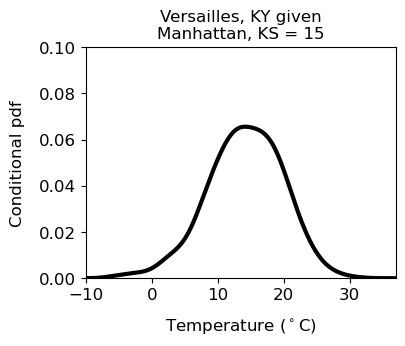

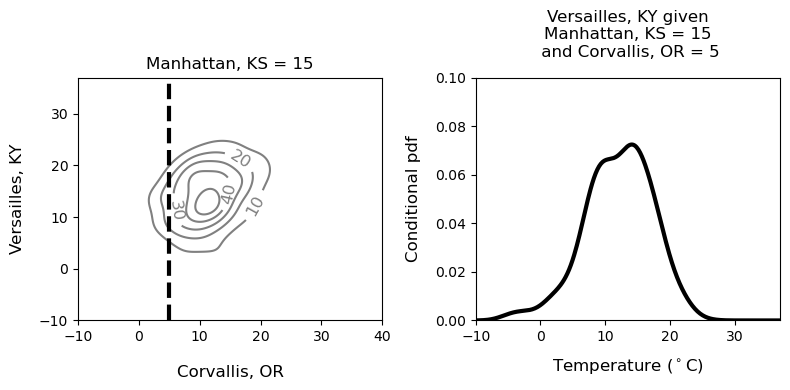

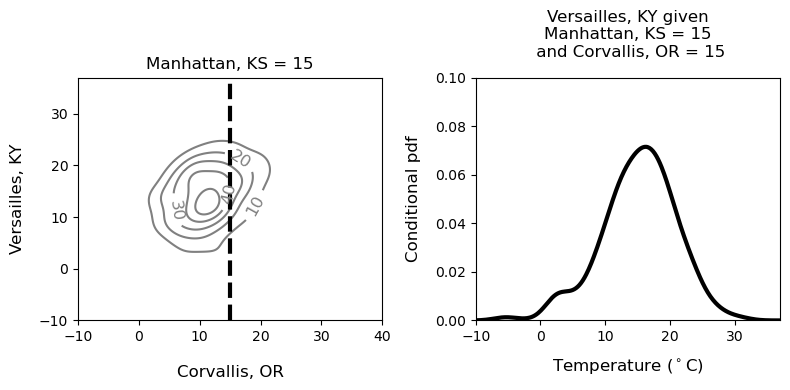

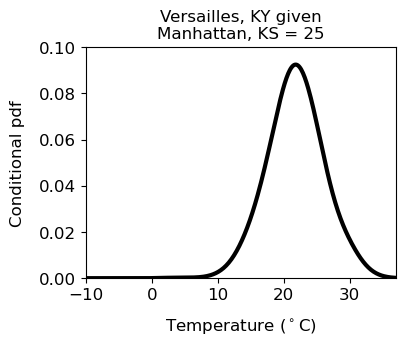

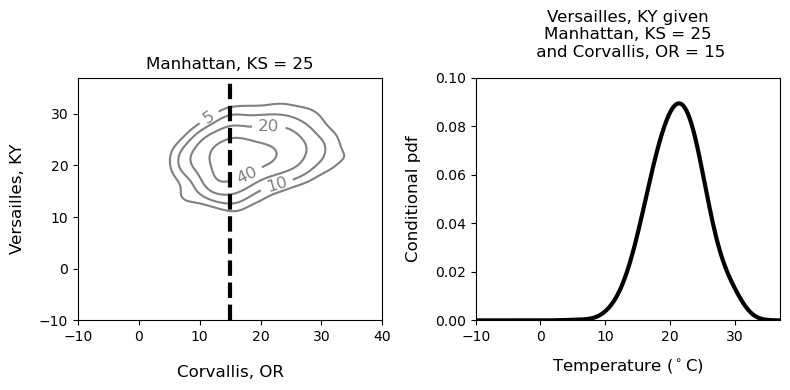

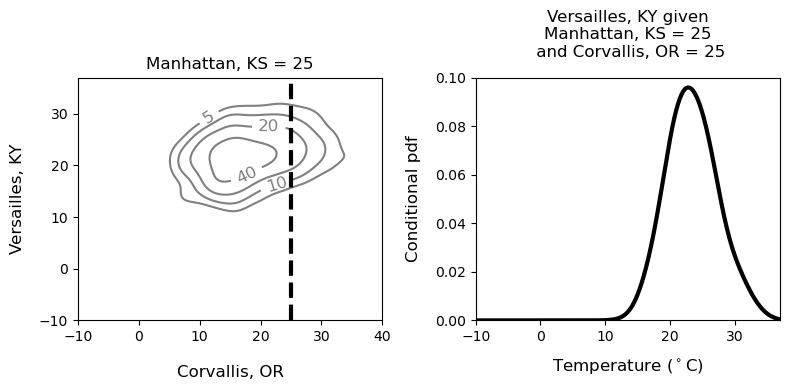

In [36]:
# The temperatures in Versailles and Corvallis are much less dependent given the temperature in Manhattan
# This takes a while to run
verbose = False
t_cond = [15,25]
t_cond_2 = [[5,15],[15,25]]
y_max = 0.1

for ind,t_val in enumerate(t_cond):
    
    bw_1D = 0.3
    bw_2D = 0.3
    bw_3D = 0.3
    
    ymin = -10
    ymax = 37
    
    kde = KDE_cond(temperature_2,temperature_1,t_val,t_2,bw_1D=bw_1D,bw_2D=bw_2D,verbose=verbose)
    plt.figure(figsize=(4,3))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.plot(t_2,kde,color="black",lw=3)
    plt.xlim([ymin,ymax])
    plt.ylim([0,y_max])
    plt.ylabel(r"Conditional pdf",fontsize=font_size,labelpad=10)
    plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=10)
    plt.title(station_names[1] + " given\n"+station_names[0] + " = " + str(t_val),fontsize=font_size)
        
    for ind_2,t_val_2 in enumerate(t_cond_2[ind]):
        
            bw_1D = 0.3
            bw_2D = 0.3
            bw_3D = 0.3
        
            fig, axes = plt.subplots(1, 2, figsize=(8,4),width_ratios=[1,1])
            ymin = -10
            ymax = 37

            levels = [10,20,30,40,50]
            levels_aux = [5,10,20,40]
            kde = KDE_2D_cond(temperature_3,temperature_2,temperature_1,t_val,t_3,t_2,bw_1D=bw_1D,bw_3D=bw_3D,verbose=verbose)
            if ind == 1:
                CS = axes[0].contour(t_3,t_2, 1e4*kde, levels=levels_aux,colors='gray')
            else:
                CS = axes[0].contour(t_3,t_2, 1e4*kde, levels=levels,colors='gray')
            axes[0].clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=font_size_ticks)
            axes[0].vlines(t_val_2,ymin,ymax,lw=3,ls="dashed",color="black")
            axes[0].set_ylim([ymin,ymax])
            axes[0].set_xlim([xmin,xmax])
            axes[0].set_ylabel(station_names[1],fontsize=font_size,labelpad = 10)
            axes[0].set_xlabel(station_names[2],fontsize=font_size,labelpad = 15)
            axes[0].set_title(station_names[0] + " = " + str(t_val),fontsize=font_size)
        
            kde = KDE_cond_2(temperature_2,temperature_1,temperature_3,t_val,t_val_2,t_2,bw_2D=bw_2D,bw_3D=bw_3D,verbose=verbose)
            axes[1].plot(t_2,kde,color="black",lw=3)
            axes[1].set_xlim([ymin,ymax])
            axes[1].set_ylim([0,y_max])
            axes[1].set_ylabel(r"Conditional pdf",fontsize=font_size,labelpad=10)
            axes[1].set_xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=10)
            axes[1].set_title(station_names[1] + " given\n" + station_names[0] + " = " + str(t_val) + "\n and " + station_names[2] + " = " + str(t_val_2),
                              fontsize=font_size,pad=15)
            plt.tight_layout();